In [20]:
from SeismicReduction import *
import pickle
import torch.nn as nn

def train(epoch, model, optimizer, train_loader, beta=1, recon_loss_method='mse'):
    """
    Trains a single epoch of the vae model.

    Parameters
    ----------
    epoch : int
        epoch number being trained
    model : torch.nn.module
        model being trained, here a vae
    optimizer : torch.optim
        optmizer used to train model
    train_loader : torch.utils.data.DataLoader
        data loader used for training
    beta : float
        beta parameter for the beta-vae
    recon_loss_method : str
        specifies the reconstruction loss technique

    Returns
    -------
    trains the model and returns training loss for the epoch

    """
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)

        optimizer.zero_grad()
        
        recon_batch, mu, logvar, _ = model(data)
        loss = loss_function(recon_batch,
                             data,
                             mu,
                             logvar,
                             window_size=data.shape[-1],
                             beta=beta,
                             recon_loss_method=recon_loss_method)
        # print('batch:', batch_idx, 'loss:', loss.item())
        loss.backward()

        # 'loss' is the SUM of all vector to vector losses in batch
        train_loss += loss.item()  # * data.size(0)  # originally

#         print('batch:', batch_idx, 'to add to total:', loss.item())
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    # print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss), len(train_loader.dataset))
    return train_loss

# load data
file_pi2 = open('./pickled/data.pickle', 'rb')
dataholder = pickle.load(file_pi2)
file_pi2.close()

In [21]:
# VAE 1 ( details: normal)
class VAE(nn.Module):
    """
    Pytorch implementation of vae.
    """
    def __init__(self, hidden_size, shape_in):
        super(VAE, self).__init__()

        #  Architecture paramaters
        shape = shape_in[-1]

        assert shape % 4 == 0, 'input dimension for VAE must be factor of 4'

        # specified reduction factor of each convolution, if layer number or stride is changed update this list!!
        reductions = [0.5, 0.5, 0.5]

        self.last_conv_channels = 34  # number of channels after last convolution

        # find the resultant dimension post convolution layer processing
        post_conv = self.post_conv_dim(shape, reductions)

        self.linear_dimension = post_conv * self.last_conv_channels

        # Encoder
        self.conv1 = nn.Conv1d(2, 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(32, self.last_conv_channels, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(self.linear_dimension, 128)

        # Latent space
        self.fc21 = nn.Linear(128, hidden_size)
        self.fc22 = nn.Linear(128, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, self.linear_dimension)
        self.deconv1 = nn.ConvTranspose1d(self.last_conv_channels, 32,kernel_size=4,stride=2,padding=1)
        self.deconv2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv1d(32, 2, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def post_conv_dim(self, in_shape, conv_reductions):
        """
        Calculates the dimension of the data at the end of convolutions.

        Parameters
        ----------
        in_shape : int
            Input dimension.
        conv_reductions : list
            List that specifies the reduction factor for each convolution, generally 1/stride of each layer.

        Returns
        -------
        int dimension post convolutions based on input dimension.
        """
        for i in conv_reductions:
            in_shape = int(np.ceil(
                in_shape * i))  #  calc the resultant size from each conv
        return in_shape

    def encode(self, x):
        """
        Encode the input into latent space variables.

        Parameters
        ----------
        x : array_like
            Input data array.

        Returns
        -------
        Latent space representation.
        """
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1 = self.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        """
        Decode from latent space back into input dimension.

        Parameters
        ----------
        z : array_like
            Latent space representation.

        Returns
        -------
        Reconstructed data array.
        """
        h3 = self.relu(self.fc3(z))
        out = self.relu(self.fc4(h3))
        out = out.view(out.size(0), self.last_conv_channels,
                       int(self.linear_dimension / self.last_conv_channels))
        out = self.relu(self.deconv1(out))
        out = self.relu(self.deconv2(out))
        out = self.relu(self.deconv3(out))
        out = self.conv5(out)
        return out

    def forward(self, x):
        """
        __call__ function for the class.

        Parameters
        ----------
        x : array_like
            Model input data.

        Returns
        -------
        decode : array_like
            Reconstructed data in dimension of input.
        mu : array_like
            Latent space representation mean
        logvar : array_like
            Latent space representation variance
        z : array_like
            Latent space representation mean

        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [22]:
# VAE 2 ( details: small)
class VAE(nn.Module):
    """
    Pytorch implementation of vae.
    """
    def __init__(self, hidden_size, shape_in):
        super(VAE, self).__init__()

        #  Architecture paramaters
        shape = shape_in[-1]

        assert shape % 4 == 0, 'input dimension for VAE must be factor of 4'

        # specified reduction factor of each convolution, if layer number or stride is changed update this list!!
        reductions = [0.5, 0.5, 0.5]

        self.last_conv_channels = 32  # number of channels after last convolution

        # find the resultant dimension post convolution layer processing
        post_conv = self.post_conv_dim(shape, reductions)

        self.linear_dimension = post_conv * self.last_conv_channels

        # Encoder
        self.conv1 = nn.Conv1d(2, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(16, self.last_conv_channels, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(self.linear_dimension, 128)

        # Latent space
        self.fc21 = nn.Linear(128, hidden_size)
        self.fc22 = nn.Linear(128, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, self.linear_dimension)
        self.deconv1 = nn.ConvTranspose1d(self.last_conv_channels, 32,kernel_size=4,stride=2,padding=1)
        self.deconv2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv1d(32, 2, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def post_conv_dim(self, in_shape, conv_reductions):
        """
        Calculates the dimension of the data at the end of convolutions.

        Parameters
        ----------
        in_shape : int
            Input dimension.
        conv_reductions : list
            List that specifies the reduction factor for each convolution, generally 1/stride of each layer.

        Returns
        -------
        int dimension post convolutions based on input dimension.
        """
        for i in conv_reductions:
            in_shape = int(np.ceil(
                in_shape * i))  #  calc the resultant size from each conv
        return in_shape

    def encode(self, x):
        """
        Encode the input into latent space variables.

        Parameters
        ----------
        x : array_like
            Input data array.

        Returns
        -------
        Latent space representation.
        """
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1 = self.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        """
        Decode from latent space back into input dimension.

        Parameters
        ----------
        z : array_like
            Latent space representation.

        Returns
        -------
        Reconstructed data array.
        """
        h3 = self.relu(self.fc3(z))
        out = self.relu(self.fc4(h3))
        out = out.view(out.size(0), self.last_conv_channels,
                       int(self.linear_dimension / self.last_conv_channels))
        out = self.relu(self.deconv1(out))
        out = self.relu(self.deconv2(out))
        out = self.relu(self.deconv3(out))
        out = self.conv5(out)
        return out

    def forward(self, x):
        """
        __call__ function for the class.

        Parameters
        ----------
        x : array_like
            Model input data.

        Returns
        -------
        decode : array_like
            Reconstructed data in dimension of input.
        mu : array_like
            Latent space representation mean
        logvar : array_like
            Latent space representation variance
        z : array_like
            Latent space representation mean

        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [25]:
# VAE 3 ( details: large)
class VAE(nn.Module):
    """
    Pytorch implementation of vae.
    """
    def __init__(self, hidden_size, shape_in):
        super(VAE, self).__init__()

        #  Architecture paramaters
        shape = shape_in[-1]

        assert shape % 4 == 0, 'input dimension for VAE must be factor of 4'

        # specified reduction factor of each convolution, if layer number or stride is changed update this list!!
        reductions = [0.5, 0.5, 0.5]

        self.last_conv_channels = 128  # number of channels after last convolution

        # find the resultant dimension post convolution layer processing
        post_conv = self.post_conv_dim(shape, reductions)

        self.linear_dimension = post_conv * self.last_conv_channels

        # Encoder
        self.conv1 = nn.Conv1d(2, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(4, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(16, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(64, self.last_conv_channels, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(self.linear_dimension, 128)

        # Latent space
        self.fc21 = nn.Linear(128, hidden_size)
        self.fc22 = nn.Linear(128, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size, 128)
        self.fc4 = nn.Linear(128, self.linear_dimension)
        self.deconv1 = nn.ConvTranspose1d(self.last_conv_channels, 32,kernel_size=4,stride=2,padding=1)
        self.deconv2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv1d(32, 2, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def post_conv_dim(self, in_shape, conv_reductions):
        """
        Calculates the dimension of the data at the end of convolutions.

        Parameters
        ----------
        in_shape : int
            Input dimension.
        conv_reductions : list
            List that specifies the reduction factor for each convolution, generally 1/stride of each layer.

        Returns
        -------
        int dimension post convolutions based on input dimension.
        """
        for i in conv_reductions:
            in_shape = int(np.ceil(
                in_shape * i))  #  calc the resultant size from each conv
        return in_shape

    def encode(self, x):
        """
        Encode the input into latent space variables.

        Parameters
        ----------
        x : array_like
            Input data array.

        Returns
        -------
        Latent space representation.
        """
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1 = self.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        """
        Decode from latent space back into input dimension.

        Parameters
        ----------
        z : array_like
            Latent space representation.

        Returns
        -------
        Reconstructed data array.
        """
        h3 = self.relu(self.fc3(z))
        out = self.relu(self.fc4(h3))
        out = out.view(out.size(0), self.last_conv_channels,
                       int(self.linear_dimension / self.last_conv_channels))
        out = self.relu(self.deconv1(out))
        out = self.relu(self.deconv2(out))
        out = self.relu(self.deconv3(out))
        out = self.conv5(out)
        return out

    def forward(self, x):
        """
        __call__ function for the class.

        Parameters
        ----------
        x : array_like
            Model input data.

        Returns
        -------
        decode : array_like
            Reconstructed data in dimension of input.
        mu : array_like
            Latent space representation mean
        logvar : array_like
            Latent space representation variance
        z : array_like
            Latent space representation mean

        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [26]:
class VaeModel(ModelAgent):
    """
    Runs the VAE model to reduce the seismic data to an arbitrary sized dimension, visualised in 2 via UMAP.
    """
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    def create_dataloader(self, test_size=0.5, batch_size=32):
        """
        Create pytorch data loaders for use in vae training, testing and running.

        Parameters
        ----------
        batch_size : int
            Size of data loader batches.

        Returns
        -------
        Modifies object data loader attributes.

        """
        # create torch tensor
        assert self.input.shape[1] == 2, 'Expected a three dimensional input with 2 channels'
        X = torch.from_numpy(self.input).float()

        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        split = ShuffleSplit(n_splits=1, test_size=test_size)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      **kwargs)

    def train_vae(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse'):
        """
        Handles the training of the vae model.

        Parameters
        ----------
        epochs : int
            Number of complete passes over the whole training set.
        hidden_size : int
            Size of the latent space of the vae.
        lr : float.
            Learning rate for the vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation

        Returns
        -------
        None

        """
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size,
                         self.input.shape)  # Inititalize the model

        optimizer = optim.Adam(self.model.parameters(),
                               lr=lr,
                               betas=(0.9, 0.999))
    


        if self.plot_loss:
            liveloss = PlotLosses()
            liveloss.skip_first = 0
            liveloss.figsize = (16, 10)

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch, self.model, optimizer, self.train_loader, recon_loss_method=recon_loss_method)  # Train model on train dataset
            
            testl = test(epoch, self.model, self.test_loader, recon_loss_method=recon_loss_method)

            if self.plot_loss:  # log train and test losses for dynamic plot
                logs = {}
                logs['' + 'ELBO'] = tl
                logs['val_' + 'ELBO'] = testl
                liveloss.update(logs)
                liveloss.draw()
                
        return testl

    def run_vae(self):
        """
        Run the full data set through the trained vae model.

        Returns
        -------
        Modifies the zs attribute, an array of shape (number_traces, latent_space)
        """
        _, zs = forward_all(self.model, self.all_loader)
        return zs.numpy()

    def reduce(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse', plot_loss=True, test_size=0.5):
        """
        Controller function for the vae model.

        Parameters
        ----------
        epochs : int
            Number of epochs to run vae model.
        hidden_size : int
            Size of the vae model latent space representation.
        lr : float
            Learning rate for vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation
        plot_loss : bool
            Control on whether to plot the loss on vae training.

        Returns
        -------
        Modifies embedding attribute via generation of the low dimensional representation.

        """
        if hidden_size < 2:
            raise Exception('Please use hidden size > 1')

        self.plot_loss = plot_loss  # define whether to plot training losses or not
        self.create_dataloader(test_size=test_size)

        if not self.loaded_model:
            loss = self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr, recon_loss_method=recon_loss_method)

        self.embedding = self.run_vae()  # arbitrary dimension output from VAE
        
        return loss

In [27]:
### Processor
processor = Processor(dataholder)
input1 = processor(flatten=[True, 12, 52], normalise=True)

Processor has created an output with shape:  (25351, 2, 64)


In [28]:
vae = VaeModel(input1)

ModelAgent initialised


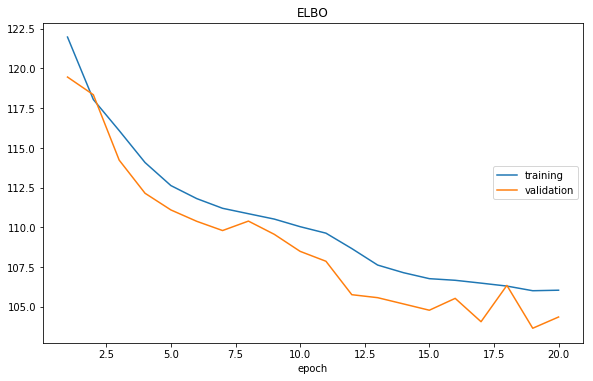

ELBO:
training   (min:  106.004, max:  121.977, cur:  106.037)
validation (min:  103.642, max:  119.459, cur:  104.349)


104.34932655534296

In [19]:
#small
vae.reduce(epochs=20, hidden_size=8, lr=0.01, plot_loss=True)

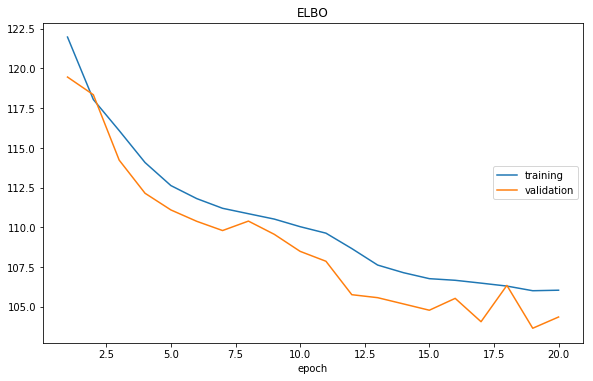

ELBO:
training   (min:  106.004, max:  121.977, cur:  106.037)
validation (min:  103.642, max:  119.459, cur:  104.349)


104.34932655534296

In [29]:
#large
vae.reduce(epochs=20, hidden_size=8, lr=0.01, plot_loss=True)